In [35]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic-data/train.csv
/kaggle/input/titanic-data/test.csv


In [36]:
train_data = pd.read_csv("/kaggle/input/titanic-data/train.csv")
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [37]:
train_data.shape

(891, 12)

In [38]:
train_data.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [39]:
unique_value_counts_train = train_data.nunique()
print(unique_value_counts_train)

PassengerId    891
Survived         2
Pclass           3
Name           891
Sex              2
Age             88
SibSp            7
Parch            7
Ticket         681
Fare           248
Cabin          147
Embarked         3
dtype: int64


In [40]:
missing_value_counts_train = train_data.isnull().sum()
print(missing_value_counts_train)

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


In [41]:
test_data = pd.read_csv("/kaggle/input/titanic-data/test.csv")
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [42]:
test_data.shape

(418, 11)

In [43]:
unique_value_counts_test = test_data.nunique()
print(unique_value_counts_test)

PassengerId    418
Pclass           3
Name           418
Sex              2
Age             79
SibSp            7
Parch            8
Ticket         363
Fare           169
Cabin           76
Embarked         3
dtype: int64


In [44]:
missing_value_counts_test = test_data.isnull().sum()
print(missing_value_counts_test)

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


Conclusions from above results:
- Drop Name from features
- Convert Sex to 0 if 'male', 1 if 'female'
- If Age is missing, convert to 0, otherwise set Age to 1
- Create a new feature, FamSz, equal to the sum of SibSp and Parch
- Drop Ticket from features
- Drop Fare, as this feature will be correlated with Pclass 
- Drop Cabin, as this feature also is likely correlated with Pclass
- If Embarked is missing, convert to the mode (see below)
- Convert Embarked to numeric values (1,2,3)

In [45]:
# Define a function to perform the data transformations
def transform_data(data):
    
    # Drop 'Name' column
    data.drop(columns=['Name'], inplace=True)
    
    # Convert 'Sex' to 0 for 'male' and 1 for 'female'
    sex_mapping = {'male': 0, 'female': 1}
    data['Sex'] = data['Sex'].map(sex_mapping)
    
    # Fill missing values in 'Age' with 0
    data['Age'] = data['Age'].fillna(0)

    # Map non-missing values to 1
    data['Age'] = data['Age'].apply(lambda x: 1 if x > 0 else x)

    # Create a new feature 'FamSz' by summing 'SibSp' and 'Parch'
    data['FamSz'] = data['SibSp'] + data['Parch']
    
    # Drop 'Ticket' column
    data.drop(columns=['Ticket'], inplace=True)
    
    # Drop Fare, as this feature will be correlated with Pclass
    data = data.drop(columns=['Fare'])
    
    # Drop Cabin, as this feature also is likely correlated with Pclass
    data = data.drop(columns=['Cabin'])
    
    # Fill missing values in 'Embarked' with the mode
    embarked_mode = data['Embarked'].mode()[0]
    data['Embarked'].fillna(embarked_mode, inplace=True)
    
    # Convert 'Embarked' to numeric values (1, 2, 3)
    embarked_mapping = {'S': 1, 'C': 2, 'Q': 3}
    data['Embarked'] = data['Embarked'].map(embarked_mapping)
    
    return data

# Apply the transformations to both training and testing data
train_data = transform_data(train_data)
test_data = transform_data(test_data)

# Verify the transformations
print(train_data.head())
print(test_data.head())

   PassengerId  Survived  Pclass  Sex  Age  SibSp  Parch  Embarked  FamSz
0            1         0       3    0  1.0      1      0         1      1
1            2         1       1    1  1.0      1      0         2      1
2            3         1       3    1  1.0      0      0         1      0
3            4         1       1    1  1.0      1      0         1      1
4            5         0       3    0  1.0      0      0         1      0
   PassengerId  Pclass  Sex  Age  SibSp  Parch  Embarked  FamSz
0          892       3    0  1.0      0      0         3      0
1          893       3    1  1.0      1      0         1      1
2          894       2    0  1.0      0      0         3      0
3          895       3    0  1.0      0      0         1      0
4          896       3    1  1.0      1      1         1      2


In [46]:
unique_value_counts_train = train_data.nunique()
print(unique_value_counts_train)

missing_value_counts_train = train_data.isnull().sum()
print(missing_value_counts_train)

unique_value_counts_test = test_data.nunique()
print(unique_value_counts_test)

missing_value_counts_test = test_data.isnull().sum()
print(missing_value_counts_test)

train_data.dtypes

PassengerId    891
Survived         2
Pclass           3
Sex              2
Age              2
SibSp            7
Parch            7
Embarked         3
FamSz            9
dtype: int64
PassengerId    0
Survived       0
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Embarked       0
FamSz          0
dtype: int64
PassengerId    418
Pclass           3
Sex              2
Age              2
SibSp            7
Parch            8
Embarked         3
FamSz            9
dtype: int64
PassengerId    0
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Embarked       0
FamSz          0
dtype: int64


PassengerId      int64
Survived         int64
Pclass           int64
Sex              int64
Age            float64
SibSp            int64
Parch            int64
Embarked         int64
FamSz            int64
dtype: object

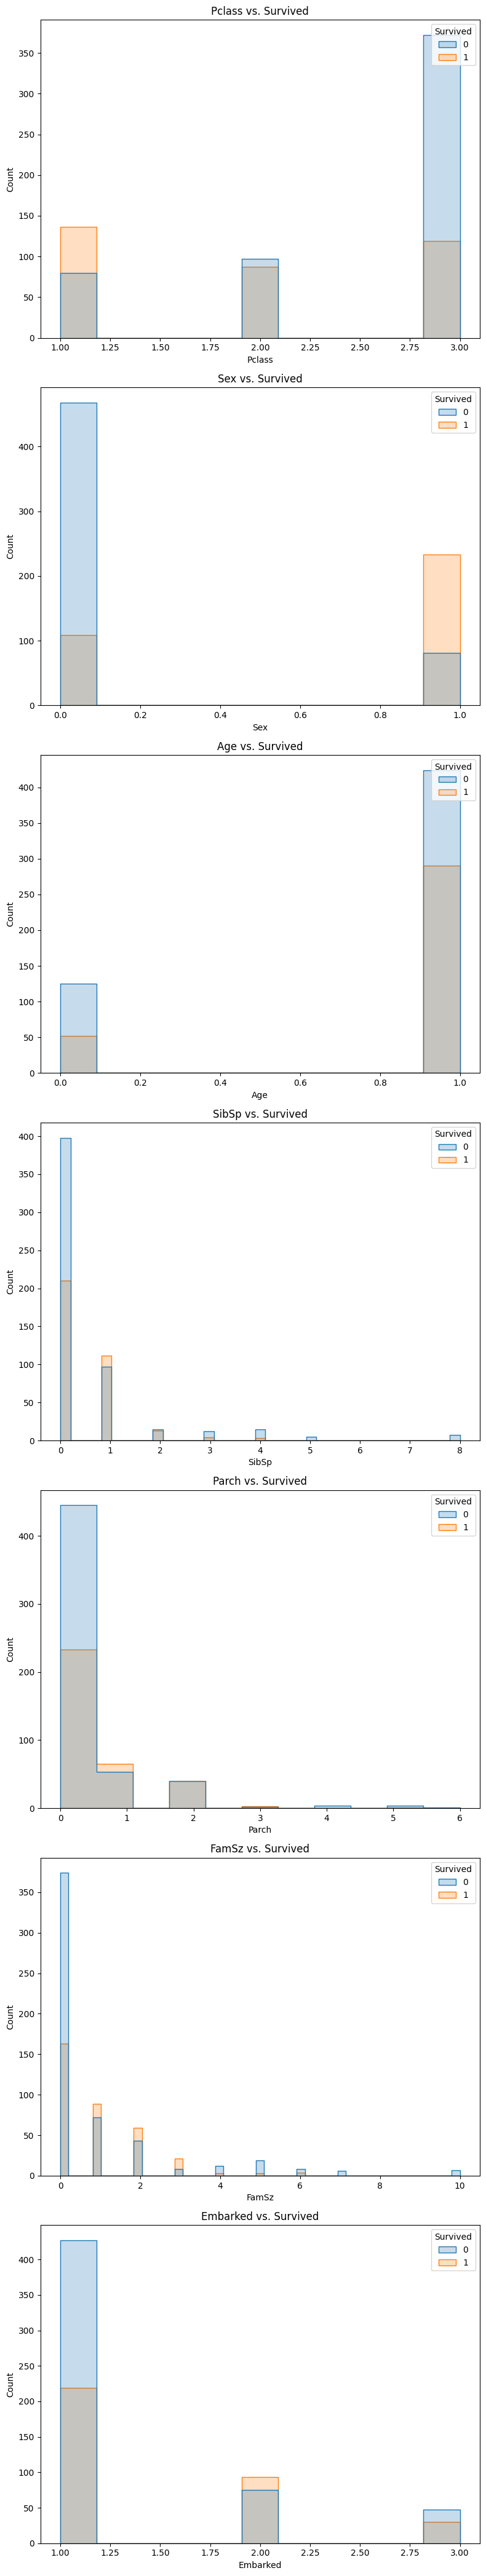

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define the numeric features you want to plot
numeric_features = ['Pclass','Sex', 'Age', 'SibSp', 'Parch', 'FamSz','Embarked']

# Create subplots for each feature
fig, axes = plt.subplots(nrows=len(numeric_features), ncols=1, figsize=(8, 6 * len(numeric_features)))

# Loop through each feature and create a grouped bar plot
for i, feature in enumerate(numeric_features):
    sns.histplot(data=train_data, x=feature, hue='Survived', element='step', common_norm=False, ax=axes[i])
    axes[i].set_title(f'{feature} vs. Survived')

plt.tight_layout()
plt.show()


In [48]:
# Separate the target variable 'Survived' from the training data
X_train = train_data.drop(columns=['PassengerId','Survived']).copy()
y_train = train_data['Survived'].copy()

# Now 'X_train' contains the features, and 'y_train' contains the target variable
# Rename test_data to correspond to this naming convention
X_test = test_data.drop(columns=['PassengerId']).copy()

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)

X_train shape: (891, 7)
y_train shape: (891,)
X_test shape: (418, 7)


In [49]:
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Initialize the scaler
scaler = StandardScaler()

# Fit and transform the scaler on your training data
X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.transform(X_test)

# Convert the NumPy arrays back to DataFrames
X_train_normalized_df = pd.DataFrame(X_train_normalized, columns=X_train.columns)
X_test_normalized_df = pd.DataFrame(X_test_normalized, columns=X_test.columns)

# Check the summary statistics of the normalized data
print("Summary Statistics for X_train_normalized:")
print(X_train_normalized_df.describe())

print("\nSummary Statistics for X_test_normalized:")
print(X_test_normalized_df.describe())

Summary Statistics for X_train_normalized:
             Pclass           Sex           Age         SibSp         Parch  \
count  8.910000e+02  8.910000e+02  8.910000e+02  8.910000e+02  8.910000e+02   
mean  -8.772133e-17  3.987333e-17 -3.638441e-17  4.386066e-17  5.382900e-17   
std    1.000562e+00  1.000562e+00  1.000562e+00  1.000562e+00  1.000562e+00   
min   -1.566107e+00 -7.376951e-01 -2.008457e+00 -4.745452e-01 -4.736736e-01   
25%   -3.693648e-01 -7.376951e-01  4.978947e-01 -4.745452e-01 -4.736736e-01   
50%    8.273772e-01 -7.376951e-01  4.978947e-01 -4.745452e-01 -4.736736e-01   
75%    8.273772e-01  1.355574e+00  4.978947e-01  4.327934e-01 -4.736736e-01   
max    8.273772e-01  1.355574e+00  4.978947e-01  6.784163e+00  6.974147e+00   

           Embarked         FamSz  
count  8.910000e+02  8.910000e+02  
mean   1.056643e-16 -3.987333e-18  
std    1.000562e+00  1.000562e+00  
min   -5.688371e-01 -5.609748e-01  
25%   -5.688371e-01 -5.609748e-01  
50%   -5.688371e-01 -5.609748

In [50]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Define a grid of hyperparameters to search
param_grid = {
    'n_estimators': [2, 4, 8, 10, 25, 50, 100],
    'max_depth': [None, 2, 3, 4, 8, 16],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4, 6],
    'bootstrap': [True, False]
}

# Create a Random Forest Classifier
rfc = RandomForestClassifier(random_state=42)

# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=10, n_jobs=-1, verbose=2)

# Fit the grid search to your training data
grid_search.fit(X_train_normalized, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Get the best model
best_model = grid_search.best_estimator_

# Use the best model for prediction and evaluation
y_test_pred_rf = best_model.predict(X_test_normalized)

Fitting 10 folds for each of 1008 candidates, totalling 10080 fits
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=2; total time=   0.0s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=4; total time=   0.0s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=4; total time=   0.0s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=4; total time=   0.0s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=8; total time=   0.0s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=8; total time=   0.0s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   

In [51]:
#Prepare output for competition

output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': y_test_pred_rf})
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!
